In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from decomposer import Decomposer
from scipy.optimize import minimize

from warnings import simplefilter
simplefilter('ignore')

In [2]:
df = pd.read_csv('gdp.csv', sep=';')
branches = ['Cp', 'Gp', 'Jp', 'Exp', 'Imp']

In [29]:
# инициализировать модель
decomposer = Decomposer(df, branches, n_components=3)
# обучить модель с регуляризацией, сделать мультистарты и выбрать лучший
decomposer.fit(multistarts=3, reg=0.1, loss_function='mse')
# обучить модель без регуляризации, инициализируя текущими значениями
# decomposer.fit(multistarts=5, reg=0, x0=decomposer, loss_function='mse')

  0%|          | 0/3 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Результат декомпозиции')

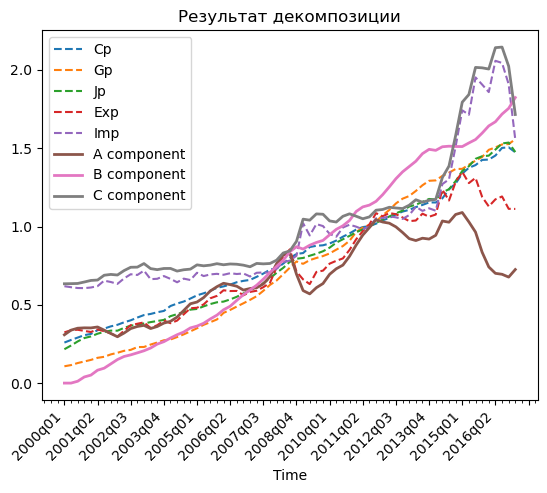

In [30]:
ax = df[branches].plot(linestyle='--')
sns.lineplot(x=df.t, y=decomposer.first_component,  label='A component',
             linewidth=2, ax=ax)
sns.lineplot(x=df.t, y=decomposer.second_component,  label='B component',
             linewidth=2, ax=ax)
if len(decomposer.components) > 2:
    sns.lineplot(x=df.t, y=decomposer.third_component,  label='C component', linewidth=2, ax=ax)
if len(decomposer.components) > 3: 
    sns.lineplot(x=df.t, y=decomposer.components[3],  label='D component', linewidth=2, ax=ax)
if len(decomposer.components) > 4:
    sns.lineplot(x=df.t, y=decomposer.components[4],  label='E component', linewidth=2, ax=ax)
ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Time")
plt.title("Результат декомпозиции")
# ax.figure.savefig('deflators.png', dpi=250)

In [31]:
"""Вывод результатов разложения (alpha, rho)"""
decomposer.summary('ces').round(4)

,Cp,Gp,Jp,Exp,Imp
alpha_0,0.2511,0.0262,0.1815,0.5586,0.0000
alpha_1,0.4013,0.8752,0.5338,0.2951,0.0191
alpha_2,0.3475,0.0986,0.2847,0.1463,0.9809
rho,5.1947,7.0868,6.5923,4.8122,6.1932


In [32]:
"""Вывод метрик"""
decomposer.summary('errors').round(4)

,Cp,Gp,Jp,Exp,Imp
MSE,0.0013,0.0002,0.0003,0.0008,0.0004
MAPE,0.0470,0.0348,0.0204,0.0333,0.0162
MAE,0.0301,0.0127,0.0124,0.0225,0.0155


Text(0.5, 1.0, 'Оценки дефляторов')

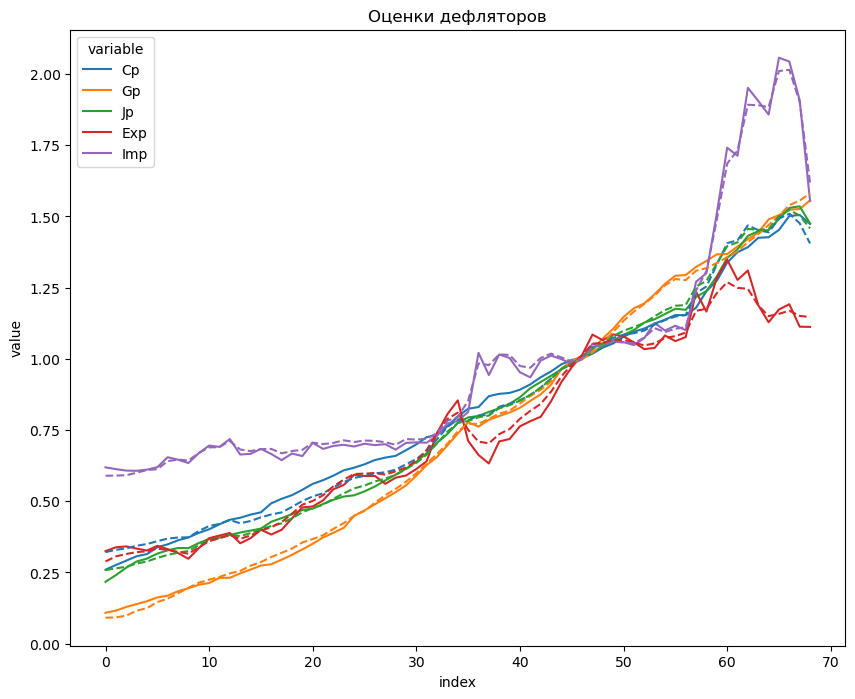

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(pd.melt(decomposer.targets.reset_index(), id_vars='index'), x='index', y='value', hue='variable')
sns.lineplot(pd.melt(decomposer.predictions.reset_index(), id_vars='index'),
             x='index', y='value', hue='variable', linestyle='--', legend=False)
plt.title("Оценки дефляторов")
# ax.figure.savefig('preds.png', dpi=250)  # сохранить картинку

In [34]:
# сохранить вычисления
decomposer.save()
# загрузить результаты вычислений
alpha, rho, components, base_coeffs, targets = [v for k, v in np.load('res.npz').items()]

### Попытка оценки объёмов компонент ВВП

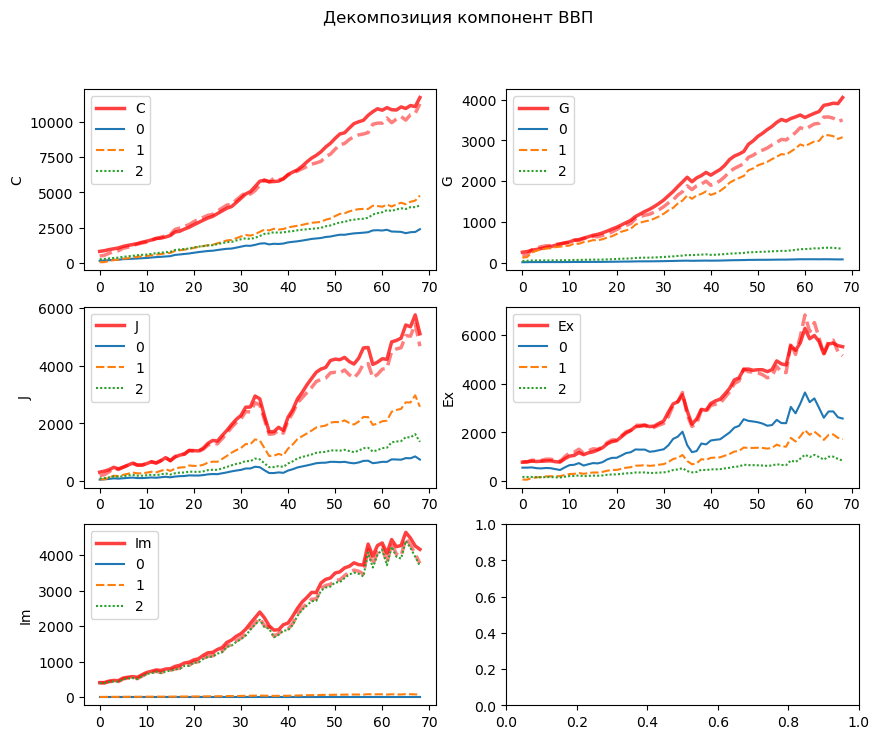

In [35]:
"""Вроде бы пока что работает не совсем праильно"""
X = df[[i[:-1] for i in decomposer.branches]].to_numpy()
res = decomposer.estimate_x(X)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
for k, branch in enumerate(branches):
    i, j = np.divmod(k, 2)
    sns.lineplot(df[branch[:-1]], ax=ax[i, j], color='red', label=branch[:-1], alpha=0.75, linewidth=2.5)
    sns.lineplot(res[:, k].T.sum(axis=1), ax=ax[i, j], color='red', linestyle='--', alpha=0.5, linewidth=2.5)
    sns.lineplot(res[:, k].T , ax=ax[i, j], linestyle='--')
plt.suptitle("Декомпозиция компонент ВВП");
# fig.savefig('decomposition.png', dpi=250) 